<h1 style="text-align: center;">Breaking RSA: An Implementation of Shor's Algorithm in Quantum Cryptography</h1>
<br>
<p style="text-align: center;"><strong>Prepared for:</strong> Dr. Sultan Almuhammadi</p>
<p style="text-align: center;"><strong>Prepared by:</strong> Ahmed Almalki</p>
<hr>

## Abstract:
This project explores the practical application of Shor's algorithm in breaking RSA encryption through quantum computing. My objective is to implement Shor's algorithm using Qiskit, an open-source quantum computing software development framework, to demonstrate the vulnerability of public-key cryptographic systems to quantum attacks. To date, I have developed a quantum circuit that successfully factors integers using simulated quantum processors. The implementation has been tested on small integers to validate the algorithm's functionality. Preliminary time complexity analysis suggests scalability to more significant integers with an increase in qubit resources. My ongoing work aims to refine the algorithm's efficiency and prepare for a demonstration on an actual quantum processor.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_city, plot_state_hinton

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from fractions import Fraction

from sympy import isprime

<img src="//raw.githubusercontent.com/qiskit-community/qiskit-textbook/0ae905083ec3872d7ddc6bb4001d5468f476d93f/content/ch-algorithms/images/shor_circuit_1.svg">

# Build `Controlled U Gate`
- Identify `n` and `m` qubits lengths.
- Determine if the given `a` is accepted value.
- Identify the required x gates by `a` XOR `1` 
- Build the circuit.

In [2]:
def c_amodN(a, N, power, draw=False):
#     if N==15:
#         return _c_amod15(a, power)
 
    # identify n-length and m-length
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    
    # identify accepted `a` values
    ns=[]
    for n in range(2,N):
        if math.gcd(n,N)==1:
            ns.append(n)
    
    if(draw):
        return _c_amodN_print(a, N, ns, n_len, m_len, power)
    
    if a not in ns:
        raise ValueError(f"'a' must be {ns}")
    U = QuantumCircuit(n_len)
    
    for i, bit in enumerate(format(pow(a,power,N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)

    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}"
    c_U = U.control()
         
    return c_U


# this function just to draw what inside controlled U gate
def _c_amodN_print(a, N, ns, n_len, m_len, power):        
    print(ns)
    
    U = QuantumCircuit(n_len)
    print(f"{format(a, f'0{n_len}b')} | a(bin) = {a}")
    print(f"{format(pow(a,power,N), f'0{n_len}b')} | {a}^{power} mod {N} (bin) = {pow(a,power,N)}")
    print(f"{format(pow(a,power,N)^1, f'0{n_len}b')} | x_gates")
    
    for i, bit in enumerate(format(pow(a,power,N), f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    U.barrier()
    for i, bit in enumerate(format(pow(a,power,N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    display(U.draw('mpl'))

    return U

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Shor Algorithm Implementation
---

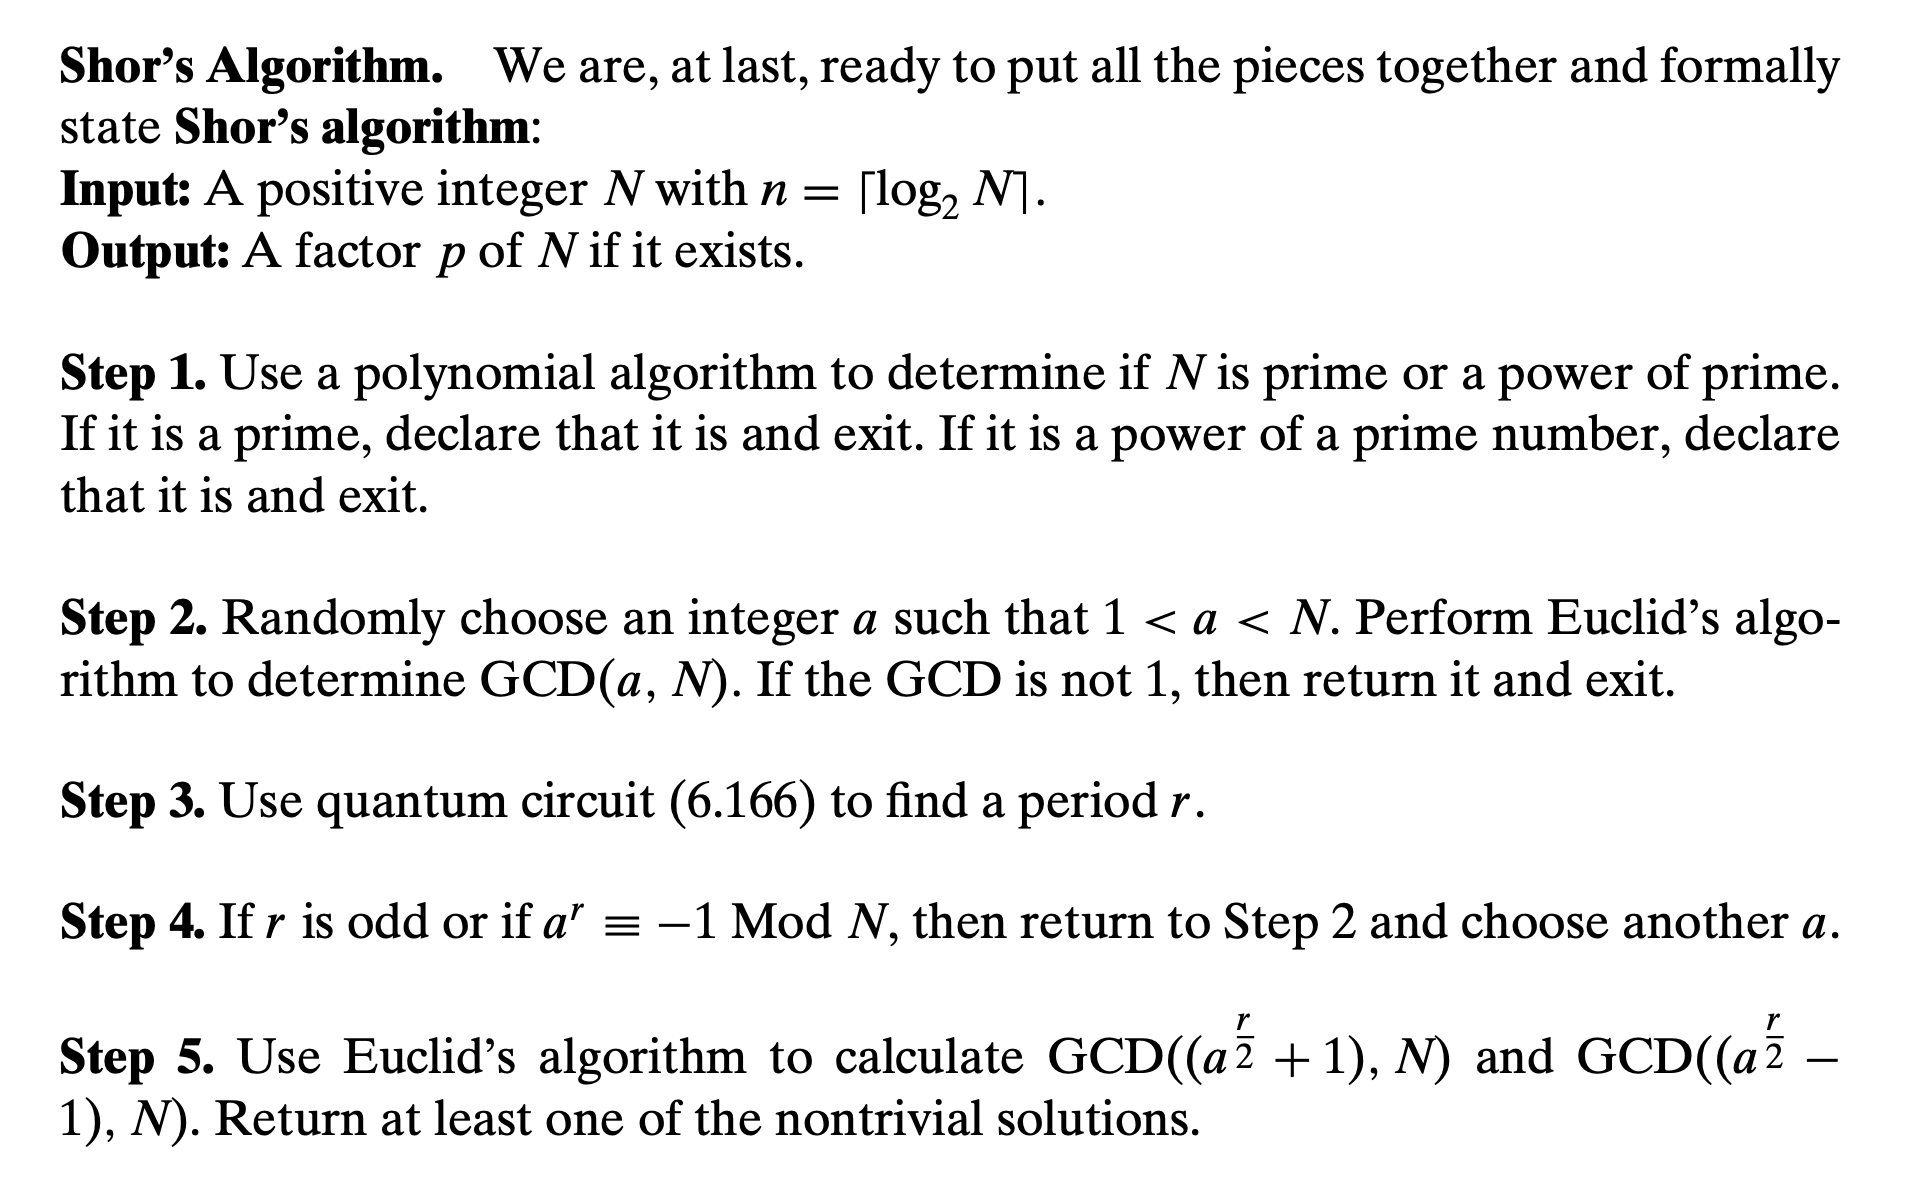

> - Yanofsky, N. S., & Mannucci, M. A. (2008). Quantum Computing for Computer Scientists. Cambridge University Press. 
---

## Step 1&2: Determining `N` & `a`
- Use a polynomial algorithm to determine if `N` is prime or a power of prime.

- $1<$ `a` $<N$.

- `n_len` $=log_2 N$.

- `m_len` $=2\times$ `n_len`.

In [4]:
N=77
a=4
n_len = math.ceil(math.log2(N))
m_len = 2*n_len

In [5]:
if isprime(N):
    print(N,f"{N} is a prime number")
else:
    print(f"{N} is not a prime number")

77 is not a prime number


[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0000100 | 4^1 mod 77 (bin) = 4
0000101 | x_gates


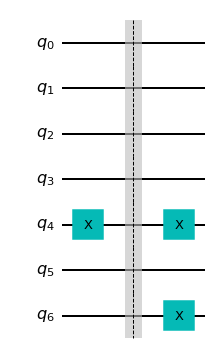

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0010000 | 4^2 mod 77 (bin) = 16
0010001 | x_gates


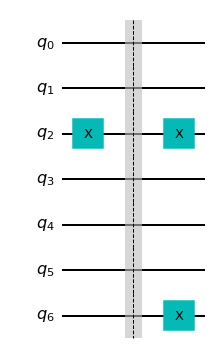

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0011001 | 4^4 mod 77 (bin) = 25
0011000 | x_gates


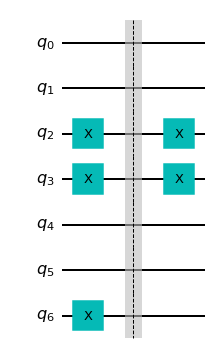

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0001001 | 4^8 mod 77 (bin) = 9
0001000 | x_gates


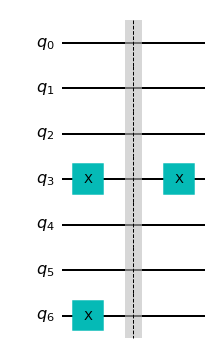

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0000100 | 4^16 mod 77 (bin) = 4
0000101 | x_gates


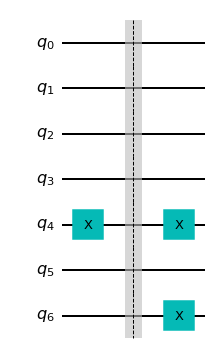

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0010000 | 4^32 mod 77 (bin) = 16
0010001 | x_gates


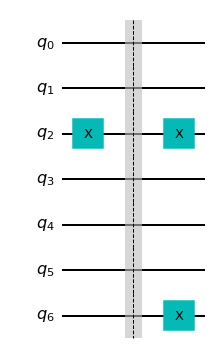

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0011001 | 4^64 mod 77 (bin) = 25
0011000 | x_gates


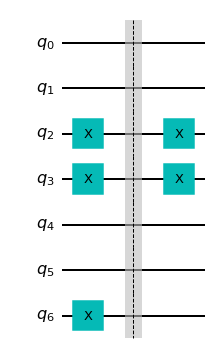

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0001001 | 4^128 mod 77 (bin) = 9
0001000 | x_gates


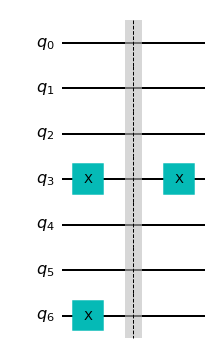

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0000100 | 4^256 mod 77 (bin) = 4
0000101 | x_gates


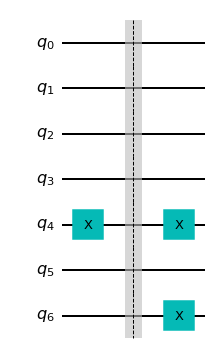

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0010000 | 4^512 mod 77 (bin) = 16
0010001 | x_gates


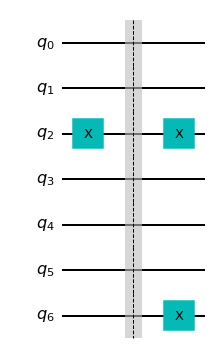

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0011001 | 4^1024 mod 77 (bin) = 25
0011000 | x_gates


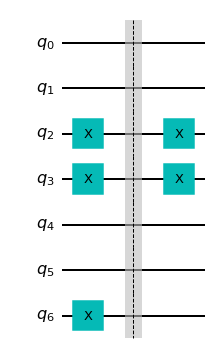

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0001001 | 4^2048 mod 77 (bin) = 9
0001000 | x_gates


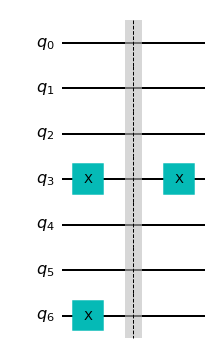

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0000100 | 4^4096 mod 77 (bin) = 4
0000101 | x_gates


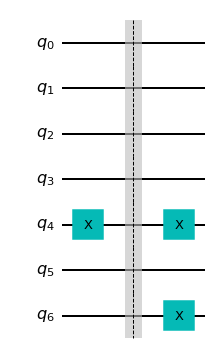

[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76]
0000100 | a(bin) = 4
0010000 | 4^8192 mod 77 (bin) = 16
0010001 | x_gates


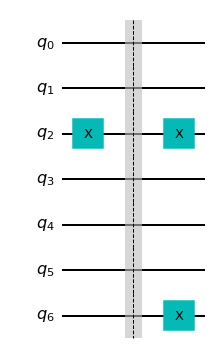

In [6]:
for p in range(m_len):
    c_amodN(a,N,2**p,draw=True)

## Step 3: Quantum Circuit to Find a Period `r`

In [7]:
# from qiskit.circuit.library import QFT

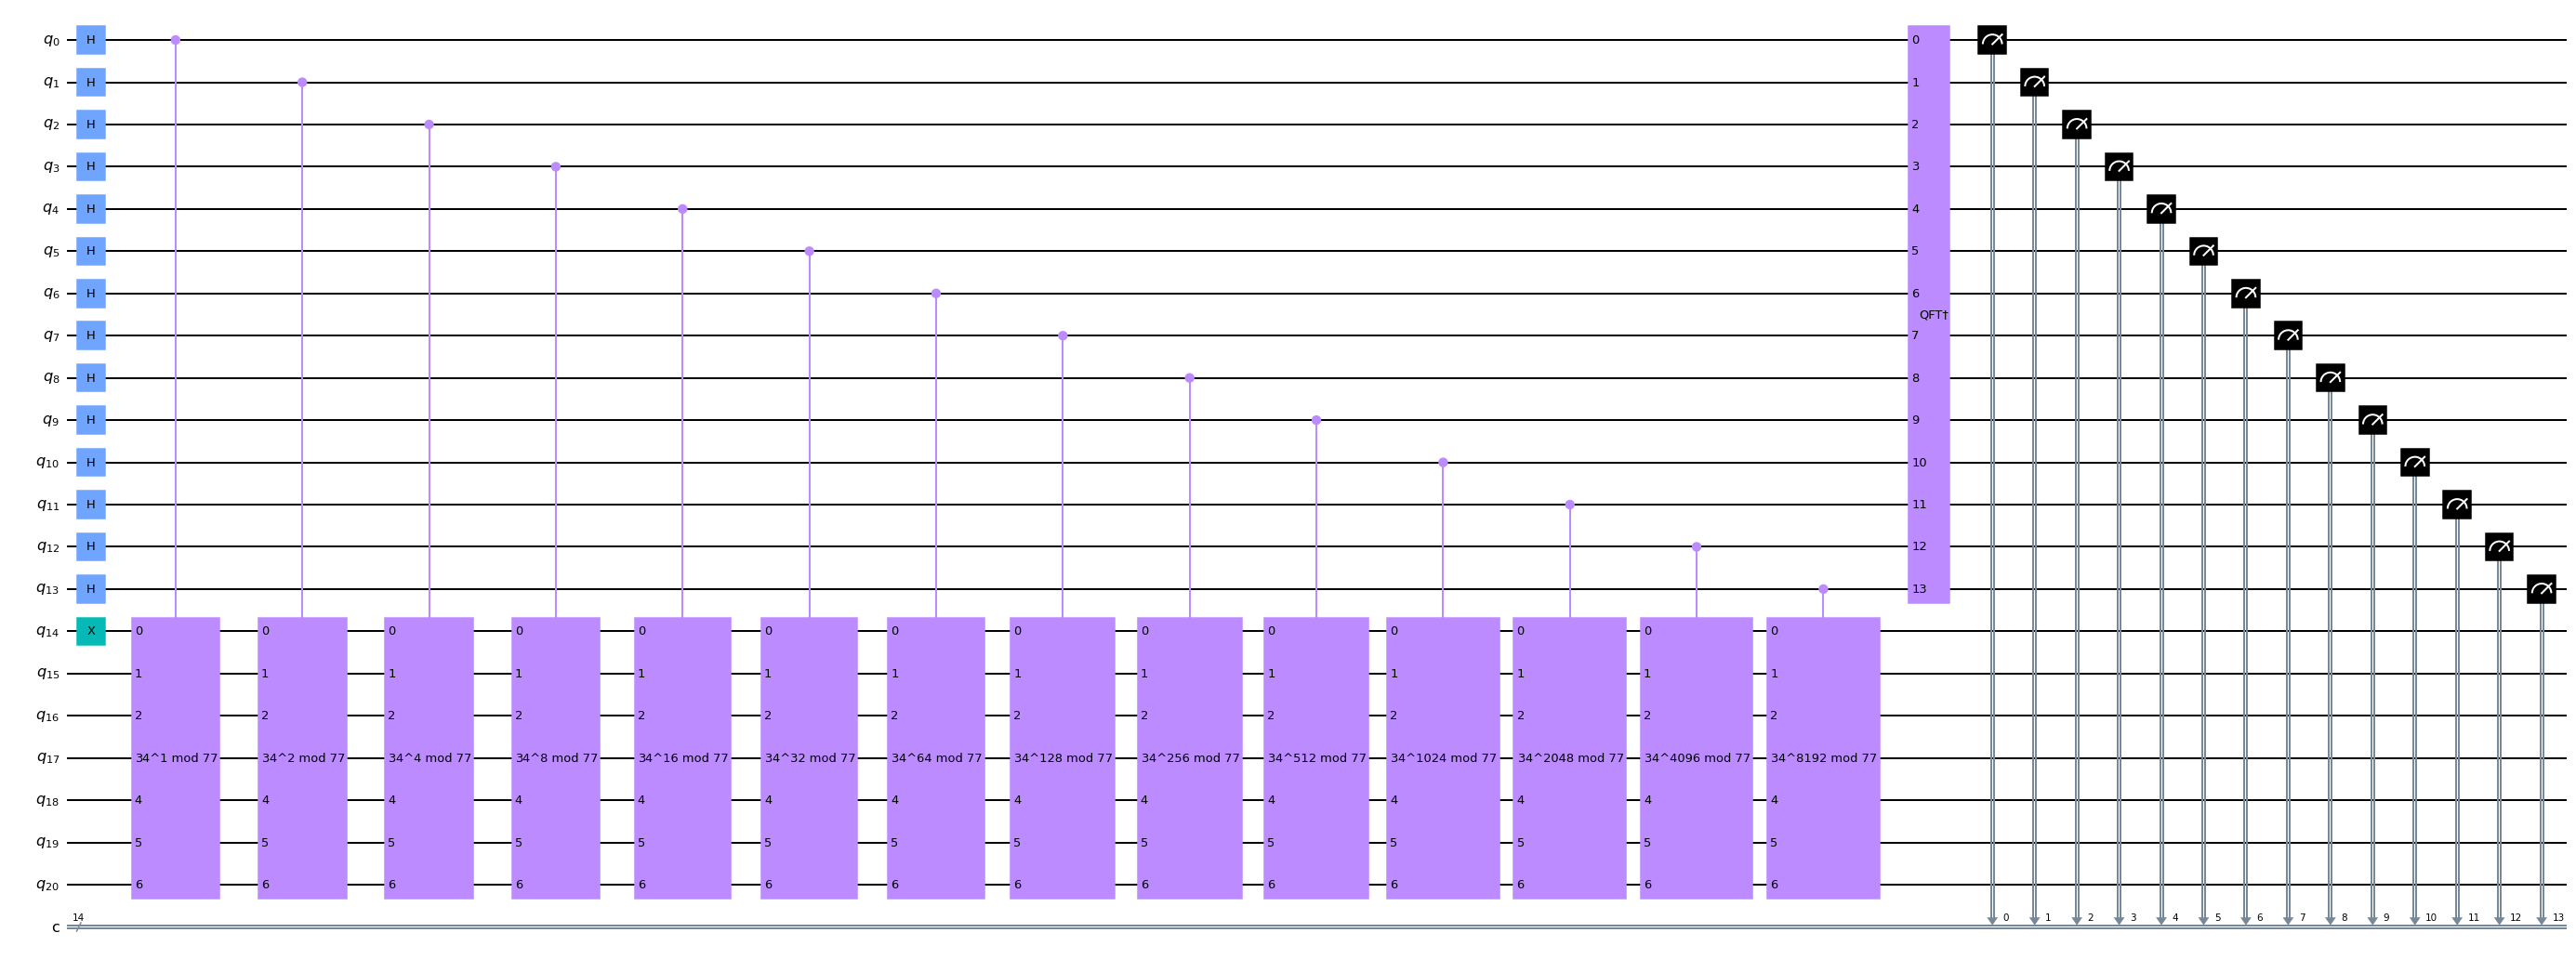

In [25]:
qc = QuantumCircuit(m_len + n_len, m_len)

# Initialize counting qubits
# in state |+>
for q in range(m_len):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(m_len)

# Do controlled-U operations
for q in range(m_len):
    qc.append(c_amodN(a, N, 2**q),
             [q] + [i+m_len for i in range(n_len)])

# Do inverse-QFT
qc.append(qft_dagger(m_len), range(m_len))
# qc.append(QFT(m_len, inverse=True), range(m_len))
# qc.append(QFT(m_len).inverse(), range(m_len))


# Measure circuit
qc.measure(range(m_len), range(m_len))
# qc.draw(fold=-1)
qc.draw(fold=-1, output='mpl', style='clifford')  # -1 means 'do not fold'

In [26]:
# counts = run_on_simulation(qc).get_counts()
# plot_histogram(counts, figsize=(17, 5))

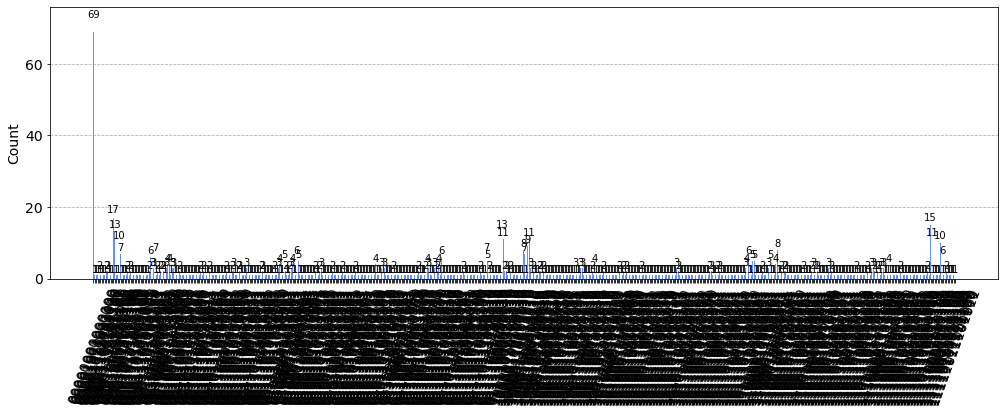

Outliers: {'00001111000100': 13, '00001110111100': 17, '00000000000000': 69, '01111000011110': 13, '11101110111100': 15}


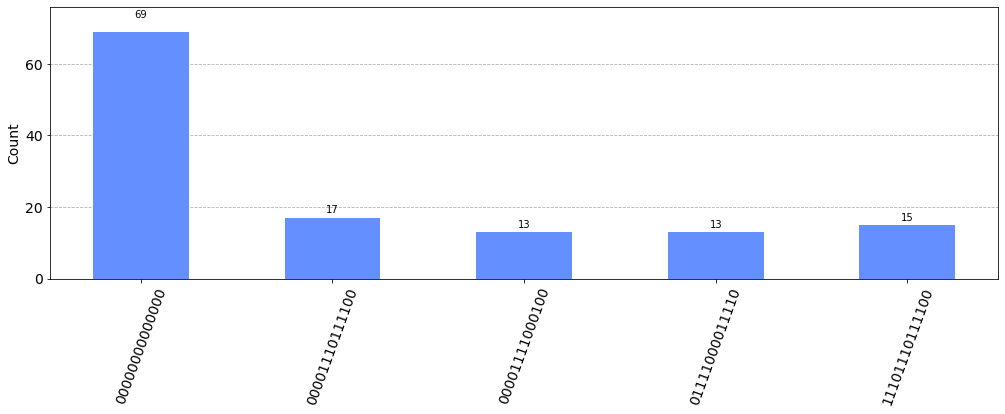

In [27]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
display(plot_histogram(counts, figsize=(17, 5)))


values = list(counts.values())
mean = np.mean(values)
std_dev = np.std(values)

# Define a threshold for outliers
threshold = 3 * std_dev

# Identify outliers
counts = {key: val for key, val in counts.items() if abs(val - mean) > threshold}

# Print outliers
print("Outliers:", counts)

# Plot histogram
plot_histogram(counts, figsize=(17, 5))


In [28]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**m_len)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**m_len} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                    Register Output               Phase
0    00001111000100(bin) = 964(dec)    964/16384 = 0.06
1    00001110111100(bin) = 956(dec)    956/16384 = 0.06
2    00000000000000(bin) =   0(dec)      0/16384 = 0.00
3   01111000011110(bin) = 7710(dec)   7710/16384 = 0.47
4  11101110111100(bin) = 15292(dec)  15292/16384 = 0.93


In [29]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.058838     1/17           17
1  0.058350     4/69           69
2  0.000000      0/1            1
3  0.470581     8/17           17
4  0.933350    14/15           15


In [30]:
# df['Guess for r'].value_counts()

In [31]:
# df.groupby('Guess for r').sum('Phase').sort_values('Phase')

In [32]:
# df.groupby('Guess for r').max('Phase').sort_values('Phase')

In [33]:
math.gcd(a, N)

1

In [34]:
def qpe_amodN(a, N):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(n_len+m_len, m_len)
    for q in range(m_len):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(m_len) # And auxiliary register in state |1>
    for q in range(m_len): # Do controlled-U operations
        qc.append(c_amodN(a, N, 2**q),
                 [q] + [i+m_len for i in range(n_len)])
    qc.append(qft_dagger(m_len), range(m_len)) # Do inverse-QFT
    qc.measure(range(m_len), range(m_len))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**m_len)
    print(f"Corresponding Phase: {phase}")
    return phase

In [35]:
phase = qpe_amodN(a, N) # Phase = s/r
Fraction(phase).limit_denominator(N)

Register Reading: 11011110001000
Corresponding Phase: 0.86767578125


Fraction(59, 68)

In [36]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

68


In [37]:
guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
print(guesses)

[1, 1]


## Step 4: if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$

In [38]:
def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False

> The function is to check if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$

## Step 5: Return the Nontrivial Solutions

Use Euclid’s algorithm to calculate $ GCD((a^{r/2} + 1), N)$ and $GCD((a^{r/2}−1),N) $ . 
Return at least one of the nontrivial solutions.

In [79]:
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amodN(a, N) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
#     if phase != 0 and check_r_condition(a, r, N):
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 00010010111100
Corresponding Phase: 0.073974609375
Result: r = 27
Guessed Factors: 1 and 1

ATTEMPT 2:
Register Reading: 10110101000011
Corresponding Phase: 0.70721435546875
Result: r = 41
Guessed Factors: 11 and 1
*** Non-trivial factor found: 11 ***
